### 0 Импорты и загрузка данных

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.base import clone
from sklearn.utils import resample

In [29]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train: {X_train.shape},  Test: {X_test.shape}")

Train: (16512, 8),  Test: (4128, 8)


### 1 Нормализация (только для ElasticNet)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### 2 Подбор гиперпараметров

Берём небольшие сетки, чтобы поиск был быстрым. Метрика для поиска - отрицательный MSE.

In [ ]:
# Gradient Boosting
gb_param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4],
}
gb_cv = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
gb_cv.fit(X_train, y_train)
best_gb = gb_cv.best_estimator_
print("Лучшие параметры GB:", gb_cv.best_params_)

In [32]:
# ElasticNet
en_param_grid = {
    "alpha": [0.1, 1.0, 10.0],
    "l1_ratio": [0.1, 0.5, 0.9],
}
en_cv = GridSearchCV(
    ElasticNet(max_iter=10000, random_state=42),
    en_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
en_cv.fit(X_train_scaled, y_train)
best_en = en_cv.best_estimator_
print("Лучшие параметры EN:", en_cv.best_params_)

Лучшие параметры EN: {'alpha': 0.1, 'l1_ratio': 0.1}


### 3 Базовые метрики (без Монте-Карло)

In [33]:
def evaluate(model, Xtr, Xts, yts, name):
    y_pred = model.predict(Xts)
    mse = mean_squared_error(yts, y_pred)
    r2  = r2_score(yts, y_pred)
    print(f"{name:10}  MSE = {mse:3.4f} | R² = {r2:.4f}")
    return y_pred, mse, r2

y_pred_gb, mse_gb, r2_gb = evaluate(best_gb, X_train, X_test, y_test, "GB baseline")
y_pred_en, mse_en, r2_en = evaluate(best_en, X_train_scaled, X_test_scaled, y_test, "EN baseline")

GB baseline  MSE = 0.2218 | R² = 0.8307
EN baseline  MSE = 0.5910 | R² = 0.5490


### 4 Монте-Карло (bootstrap bagging)

In [ ]:
def monte_carlo(model, Xtr, ytr, Xts, n_sim=50, random_state=42):
    rng = np.random.RandomState(random_state)
    preds = []
    for _ in range(n_sim):
        idx = rng.randint(0, len(Xtr), len(Xtr))
        Xb, yb = Xtr[idx], ytr[idx]
        m = clone(model)
        m.fit(Xb, yb)
        preds.append(m.predict(Xts))
    preds = np.vstack(preds)
    mean_pred = preds.mean(axis=0)
    std_pred  = preds.std(axis=0)
    return mean_pred, std_pred

# === Gradient Boosting ===
mean_gb, std_gb = monte_carlo(
    best_gb, X_train.values, y_train.values, X_test.values, n_sim=50
)
mse_gb_mc = mean_squared_error(y_test, mean_gb)
r2_gb_mc  = r2_score(y_test, mean_gb)
std_gb_mean_std = np.mean(std_gb)

# === ElasticNet ===
mean_en, std_en = monte_carlo(
    best_en, X_train_scaled, y_train.values, X_test_scaled, n_sim=50
)
mse_en_mc = mean_squared_error(y_test, mean_en)
r2_en_mc  = r2_score(y_test, mean_en)
std_en_mean_std = np.mean(std_en)

In [37]:
pd.DataFrame({
    "MSE": [mse_gb_mc, mse_en_mc],
    "R²": [r2_gb_mc, r2_en_mc],
    "Mean σ(pred)": [std_gb_mean_std, std_en_mean_std]
}, index=["Gradient Boosting", "ElasticNet"])


,MSE,R²,Mean σ(pred)
Gradient Boosting,0.216233,0.834988,0.113503
ElasticNet,0.590696,0.549228,0.013305


### 5 Визуализация

In [43]:
idx = np.arange(y_test.shape[0])

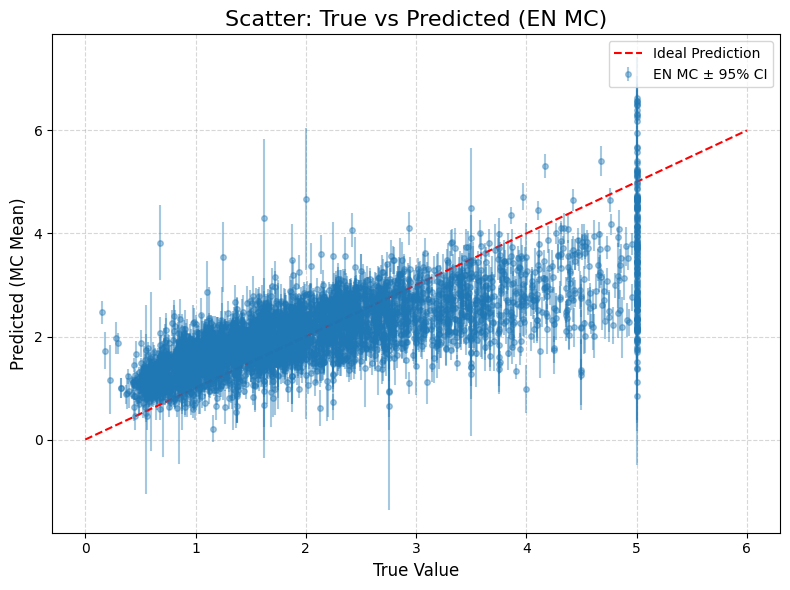

In [50]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, mean_en, yerr=1.96 * std_gb, fmt='o', alpha=0.4, markersize=4, label="EN MC ± 95% CI")
plt.plot([0, 6], [0, 6], 'r--', label="Ideal Prediction")
plt.xlabel("True Value", fontsize=12)
plt.ylabel("Predicted (MC Mean)", fontsize=12)
plt.title("Scatter: True vs Predicted (EN MC)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

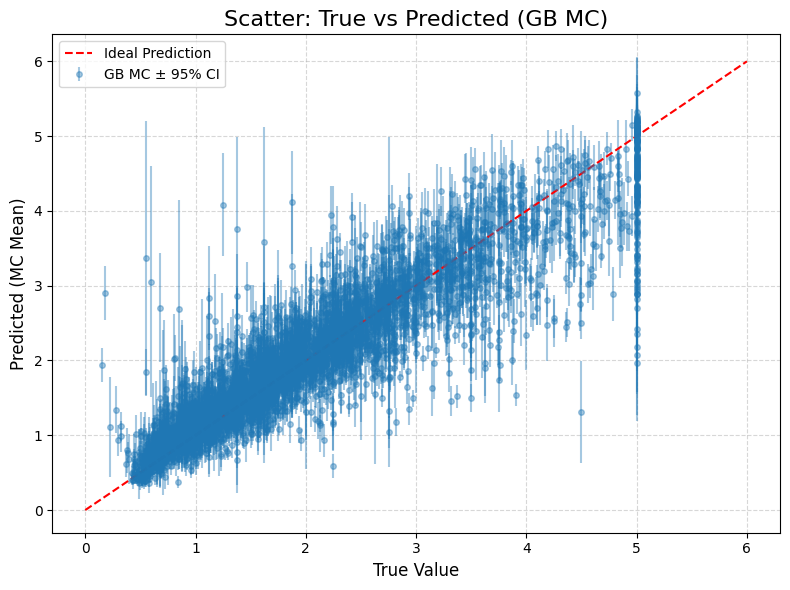

In [46]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, mean_gb, yerr=1.96 * std_gb, fmt='o', alpha=0.4, markersize=4, label="GB MC ± 95% CI")
plt.plot([0, 6], [0, 6], 'r--', label="Ideal Prediction")
plt.xlabel("True Value", fontsize=12)
plt.ylabel("Predicted (MC Mean)", fontsize=12)
plt.title("Scatter: True vs Predicted (GB MC)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

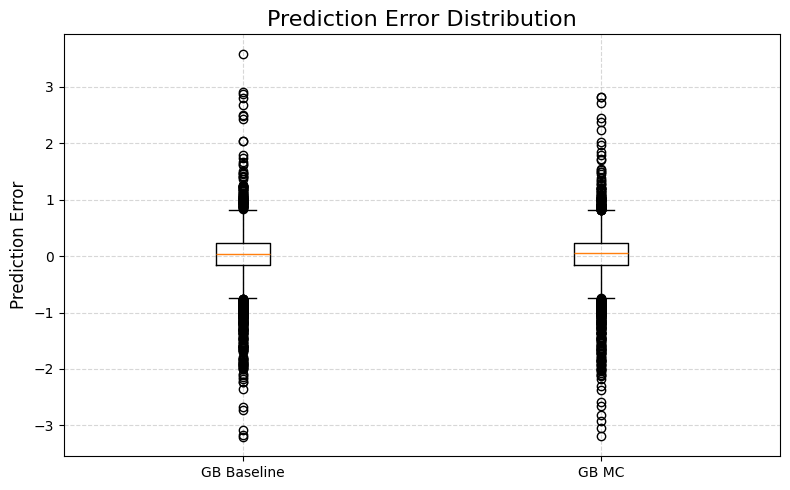

In [49]:
errors_baseline = y_pred_gb - y_test
errors_mc = mean_gb - y_test

plt.figure(figsize=(8, 5))
plt.boxplot([errors_baseline, errors_mc], tick_labels=["GB Baseline", "GB MC"])
plt.title("Prediction Error Distribution", fontsize=16)
plt.ylabel("Prediction Error", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### 6 Результаты

In [35]:
pd.DataFrame(
    {
        "MSE": [mse_gb, mse_gb_mc, mse_en, mse_en_mc],
        "R²":  [r2_gb, r2_gb_mc, r2_en, r2_en_mc],
    },
    index=["GB baseline", "GB MC", "EN baseline", "EN MC"],
)

,MSE,R²
GB baseline,0.221828,0.830718
GB MC,0.216233,0.834988
EN baseline,0.590975,0.549015
EN MC,0.590696,0.549228


Выводы:

1. Gradient Boosting заметно опережает ElasticNet по точности предсказаний (MSE и R²).

2. Несмотря на то, что у ElasticNet меньше разброс в предсказаниях (низкая σ), это связано с переупрощением модели и неспособностью уловить сложные зависимости.

3. У Gradient Boosting наблюдается небольшое, но стабильное улучшение качества после применения ансамбля по Монте-Карло (bootstrapping).

4. У ElasticNet эффекта почти нет - модель линейная, и обучение на подвыборках не приводит к заметной диверсификации предсказаний.

5. Boxplot ошибок показывает, что GB MC имеет меньшую медианную ошибку и более симметричное распределение по сравнению с baseline.